# Part 1: Basic Option Valuation
Carry out convergence studies by increasing the number of trials.  <br>
How do your results compare with the results obtained in assignment 1?  <br>
Perform numerical tests for varying values for the strike and the volatility parameter.  <br>
What is the standard error of your estimate and what does this tell you about the accuracy?

# TO DO 
### Romy:
- Maakt tabellen 2.1 + BS delta berekening
- Overleaf intro schrijven

### Jasper:
- [ ] 1 alle plotjes voor 1
- [ ] 2.2 pathwise controle
- [ ] 3 formules
- [ ] 3 coderen Asian option

### Steven:
- 2.2 sameseed/different seed allebei?
- pathwise bullshit
- Begin bij S0 of S1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import random

from scipy.stats import norm
from numba import jit
from scipy import stats

In [ ]:
# THIS IS NOW A PUT OPTION!

@jit (nopython = True)
def one_step_stock(stock_price, interest_rate, volatility, maturity):
    return stock_price * math.exp((interest_rate - 0.5 * volatility ** 2) * maturity + volatility * math.sqrt(maturity) * np.random.normal())

@jit (nopython = True)
def monte_carlo_option(trials, strike_price, stock_price, interest_rate, volatility, maturity):
    # trials are #iterations of monte carlo
    monte_results = []
    for i in range(trials):
        current_monte = one_step_stock(stock_price, interest_rate, volatility, maturity)
        if current_monte - strike_price < 0:
            monte_results.append((strike_price - current_monte) * math.exp(-interest_rate))
        else:
            monte_results.append(0)
        
    return monte_results 
    

In [ ]:
@jit (nopython = True)
def experiment():
    ''' The Monte Carlo method.'''
    T = 1
    K = 99
    r = 0.06
    S0 = 100
    sigma = 0.2

    trials = 10000
#     time0 = time.time()

    monte_total = []
    iters = 10000
    for i in range(iters):
        monte_results = monte_carlo_option(trials, K, S0, r, sigma, T)
        # print(time.time() - time0)

        # Mean and std
        monte_mean = np.mean(np.array(monte_results))
        monte_total.append(monte_mean)
    # monte_std = np.std(monte_results)
    return monte_total

In [ ]:
results = experiment()

In [ ]:
np.mean(results)

In [ ]:
#Payoff kan nooit negatief zijn 
CI95 = stats.norm.interval(0.95, loc = np.mean(results), scale = np.std(results)) 
plt.axvline(CI95[0], color = 'r', label = '95% CI')
#plt.axvline(4.77, color = 'black', linestyle = ':', label = 'Black-Scholes Price')
plt.axvline(CI95[1], color = 'r')

plt.legend()
plt.hist(results, bins = 30)
plt.ylabel('Observations')
plt.xlabel('Option price')
plt.title('Price of a put option (100000 trials)')
plt.savefig("100000trialsQ21Put.png")
plt.show()

In [ ]:
# '''  Varying the strike and the volatility. '''

# strike_list = [x for x in range(1,201)] #np.linspace(1,200)
# # print(strike_list)

# profit_list = []
# for K in strike_list:
#     profit = monte_carlo_option(trials, K, S0, r, sigma, T)
#     profit_list.append(profit)
     
# plt.plot(strike_list, profit)
# plt.title('Varying strike')
# plt.xlabel('Strike price')
# plt.ylabel('Profit or Loss')
# plt.legend()
# plt.show()

# Part 2: Estimation of Sensitivities in MC

## 1) Bump-and-revalue method.

In [ ]:
@jit (nopython = True)
def one_step_stock(stock_price, interest_rate, volatility, maturity, Z):
    return stock_price * math.exp((interest_rate - 0.5 * volatility ** 2) * maturity + volatility * math.sqrt(maturity) * Z)

@jit (nopython = True)
def monte_carlo_option(trials, strike_price, stock_price, interest_rate, volatility, maturity, randomness):
    # trials are #iterations of monte carlo
    monte_results = []
    for i in range(trials):
        current_monte = one_step_stock(stock_price, interest_rate, volatility, maturity, randomness[i])
        if strike_price - current_monte > 0:
            monte_results.append((strike_price - current_monte) * math.exp(-interest_rate))
        else:
            monte_results.append(0)
        
    return monte_results 
    

In [ ]:
# @jit (nopython = True)
def experiment(epsilon, trials, seedlist):
    ''' The Monte Carlo method.'''
    T = 1
    K = 99
    r = 0.06
    S0 = 100 + epsilon
    sigma = 0.2

    monte_total = []
    for i in range(trials):
        np.random.seed(seedlist[i])
        randommess = np.random.normal(size = trials)
        monte_results = monte_carlo_option(trials, K, S0, r, sigma, T, randommess)
        # Mean 
        monte_mean = np.mean(np.array(monte_results))
        monte_total.append(monte_mean)

    return monte_total

In [ ]:
def euler(epsilon, trials, sameseed):    
    if sameseed == True:
        seedlist = np.random.randint(1000, size = trials)
        
        bumped = np.mean(np.array(experiment(epsilon, trials, seedlist)))
        unbumped = np.mean(np.array(experiment(0, trials, seedlist)))
    else:
        
        seedlist = np.random.randint(1000, size = trials)
        bumped = np.mean(np.array(experiment(epsilon, trials, seedlist)))
        
        seedlist = np.random.randint(1000, size = trials)
        unbumped = np.mean(np.array(experiment(0, trials, seedlist)))
    
    print(unbumped)
    print(bumped)
    delta = (bumped - unbumped) / epsilon
    
    return delta

In [ ]:
""" Compute deltas for different seeds
    with epsilon 0.01, 0.02, 0.5. """

# Size 10^4
number_of_trials = int(1e4)
dif_delta4_1 = euler(1e-2, number_of_trials, True)
# dif_delta4_2 = euler(2e-2, trials = number_of_trials, randommess = randommess, sameseed=False)
# dif_delta4_5 = euler(5e-1, trials = number_of_trials, randommess = randommess, sameseed=False)

# # Size 10^5
# number_of_trials = int(1e5)
# randommess = np.random.normal(size=number_of_trials)
# dif_delta5_1 = euler(1e-2, trials = number_of_trials, randommess = randommess, sameseed=False)
# dif_delta5_2 = euler(2e-2, trials = number_of_trials, randommess = randommess, sameseed=False)
# dif_delta5_5 = euler(5e-1, trials = number_of_trials, randommess = randommess, sameseed=False)

# # Size 10^6
# number_of_trials = int(1e6)
# randommess = np.random.normal(size=number_of_trials)
# dif_delta6_1 = euler(1e-2, trials = number_of_trials, randommess = randommess, sameseed=False)
# dif_delta6_2 = euler(2e-2, trials = number_of_trials, randommess = randommess, sameseed=False)
# dif_delta6_5 = euler(5e-1, trials = number_of_trials, randommess = randommess, sameseed=False)

# # Size 10^7
# number_of_trials = int(1e7)
# randommess = np.random.normal(size=number_of_trials)
# dif_delta7_1 = euler(1e-2, trials = number_of_trials, randommess = randommess, sameseed=False)
# dif_delta7_2 = euler(2e-2, trials = number_of_trials, randommess = randommess, sameseed=False)
# dif_delta7_5 = euler(5e-1, trials = number_of_trials, randommess = randommess, sameseed=False)

In [ ]:
print(dif_delta4_1)
print(-0.326265)

In [ ]:
relative_error(-0.326265, dif_delta4_1)

In [ ]:
# """ Compute deltas for same seed 
#     with epsilon 0.01, 0.02, 0.5. """

# Size 10^4
number_of_trials = int(1e4)
randommess = np.random.normal(size=number_of_trials)
same_delta4_1 = euler(1e-2, trials = number_of_trials, randommess = randommess, sameseed=True)
same_delta4_2 = euler(2e-2, trials = number_of_trials, randommess = randommess, sameseed=True)
same_delta4_5 = euler(5e-1, trials = number_of_trials, randommess = randommess, sameseed=True)

# # Size 10^5
# number_of_trials = int(1e5)
# randommess = np.random.normal(size=number_of_trials)
# same_delta5_1 = euler(1e-2, trials = number_of_trials, randommess = randommess, sameseed=True)
# same_delta5_2 = euler(2e-2, trials = number_of_trials, randommess = randommess, sameseed=True)
# same_delta5_5 = euler(5e-1, trials = number_of_trials, randommess = randommess, sameseed=True)

# # Size 10^6
# number_of_trials = int(1e6)
# randommess = np.random.normal(size=number_of_trials)
# same_delta6_1 = euler(1e-2, trials = number_of_trials, randommess = randommess, sameseed=True)
# same_delta6_2 = euler(2e-2, trials = number_of_trials, randommess = randommess, sameseed=True)
# same_delta6_5 = euler(5e-1, trials = number_of_trials, randommess = randommess, sameseed=True)

# # Size 10^7
# number_of_trials = int(1e7)
# randommess = np.random.normal(size=number_of_trials)
# same_delta7_1 = euler(1e-2, trials = number_of_trials, randommess = randommess, sameseed=True)
# same_delta7_2 = euler(2e-2, trials = number_of_trials, randommess = randommess, sameseed=True)
# same_delta7_5 = euler(5e-1, trials = number_of_trials, randommess = randommess, sameseed=True)

In [ ]:
""" Relative error in percentage. """
def relative_error(true_value, approx_value):
    return ((true_value - approx_value) / true_value) * 100

In [ ]:
'''Analytical value'''
def black_scholes(stock_price = 100, strike_price = 80, interest_rate = 0.06, volatility = 0.2, T = 1):
    d1 = (math.log(stock_price / strike_price) + (interest_rate + (volatility ** 2) / 2) * T) / (volatility * math.sqrt(T))
    #d2 = d1 - volatility* math.sqrt(T)
    d2 = (math.log(stock_price / strike_price) + (interest_rate - (volatility ** 2) / 2) * T) / (volatility * math.sqrt(T))
   
    call = stock_price * norm.cdf(d1) - strike_price * math.exp(- interest_rate * T) * norm.cdf(d2)
    put = strike_price * math.exp(-interest_rate * T ) * norm.cdf(-d2) - stock_price * norm.cdf(-d1)

    return call, put


""" Relative error is shown with analytical value as reference. """

#The analytical value
analytical_call, analytical_put = black_scholes()
# print('The analytical price of the option:', analytical_put)

#######
# print(dif_delta4_1)
# print(dif_delta4_2)

number_of_trials = 100000
randommess = np.random.normal(size=number_of_trials)
# print(len(randommess))
check = euler(1e-8, trials = number_of_trials, randommess = randommess, sameseed=True)
print('Check', check)
#####

# Size 10^4
number_of_trials = int(1e4)
randommess = np.random.normal(size=number_of_trials)
same_delta4_1 = euler(1e-2, trials = number_of_trials, randommess = randommess, sameseed=True)
same_delta4_2 = euler(2e-2, trials = number_of_trials, randommess = randommess, sameseed=True)
same_delta4_5 = euler(5e-1, trials = number_of_trials, randommess = randommess, sameseed=True)

####
analytical_value = -0.326265
print('analytical value:', analytical_value)
print('calculated value', same_delta4_1)
error = relative_error(analytical_value, same_delta4_1)
print('Error', error)

In [ ]:
""" Relative error is shown with analytical value as reference. """

#The analytical value
analytical_call, analytical_put = black_scholes()
print('The analytical price of the option:', analytical_put)

#######
# print(dif_delta4_1)
# print(dif_delta4_2)

number_of_trials = 100000
randommess = np.random.normal(size=number_of_trials)
# print(len(randommess))
check = euler(1e-8, trials = number_of_trials, randommess = randommess, sameseed=True)
print(check)

####
error = relative_error(analytical_put, check)
print(error)

## 2)  Digital option

In [ ]:
import scipy

In [ ]:
def experiment2(epsilon, trials, seedlist):
    ''' The Monte Carlo method.'''
    T = 1
    K = 99
    S0 = 100 + epsilon
    sigma = 0.2
    r = 0.06

    monte_total = []
    for i in range(trials):
        np.random.seed(seedlist[i])
        randommess = np.random.normal(size = trials)
        monte_results = digital_option(trials, K, S0, r, sigma, T, randommess)

        monte_mean = np.mean(monte_results)
        monte_total.append(monte_mean)

    return monte_total

@jit (nopython = True)
def digital_option(trials, strike_price, stock_price, interest_rate, volatility, maturity, randomness):
    # trials are #iterations of monte carlo
    monte_results = []

    for i in range(trials):
        current_monte = one_step_stock(stock_price, interest_rate, volatility, maturity, randomness[i])
        if current_monte - strike_price > 0:
            
            monte_results.append(1 * math.exp(-interest_rate))
        else:
            monte_results.append(0)

    return monte_results

@jit (nopython = True)
def one_step_stock(stock_price, interest_rate, volatility, maturity, Z):
    return stock_price * math.exp((interest_rate - 0.5 * volatility ** 2) * maturity + volatility * math.sqrt(maturity) * Z)

In [ ]:
trials = 1000
digital_value = experiment2(0.0, trials, np.random.randint(1000, size = trials))

In [ ]:
plt.hist(digital_value)
plt.title('Value of a digital option')
plt.ylabel('Observations')
plt.xlabel('Value')
plt.show()

In [ ]:
def euler(epsilon, trials, sameseed):    
    if sameseed == True:
        seedlist = np.random.randint(1000, size = trials)
        
        bumped = np.mean(np.array(experiment2(epsilon, trials, seedlist)))
        unbumped = np.mean(np.array(experiment2(0, trials, seedlist)))
    else:
        
        seedlist = np.random.randint(1000, size = trials)
        bumped = np.mean(np.array(experiment2(epsilon, trials, seedlist)))
        
        seedlist = np.random.randint(1000, size = trials)
        unbumped = np.mean(np.array(experiment2(0, trials, seedlist)))
    
    print(unbumped)
    print(bumped)
    delta = (bumped - unbumped) / epsilon
    
    return delta

In [ ]:
euler(0.01, 1000, True)

### Sophisticated Log part

In [ ]:
@jit (nopython = True)
def log_digital_delta(iterations):
    delta_list = []
    for j in range(iterations):
        Z = np.random.normal()

        current_stock = start_stock * math.exp((interest_rate - (volatility ** 2) / 2) * maturity + volatility * (maturity ** 0.5) * Z)

        digital = 0
        if current_stock > strike_price:
            digital = 1
        delta_list.append(math.exp(-interest_rate * maturity) * digital * (Z / (volatility * start_stock * (maturity ** 0.5))))
    return delta_list

@jit (nopython = True)
def runs(iters):
    mean_list = []
    for i in range(iters):
        mean_list.append(np.mean(np.array(log_digital_delta(10000))))
    return mean_list

In [ ]:
start_stock = 100
interest_rate = 0.06
volatility = 0.2
maturity = 1
strike_price = 99
delta_list = runs(10000)


In [ ]:
#Payoff kan nooit negatief zijn 
CI95 = stats.norm.interval(0.95, loc = np.mean(delta_list), scale = np.std(delta_list)) 
plt.axvline(CI95[0], color = 'r', label = '95% CI')
plt.axvline(CI95[1], color = 'r')
plt.axvline(np.mean(delta_list), color = 'black', label = 'Mean = {0}'.format(np.mean(delta_list).round(5)))
plt.legend()
plt.hist(delta_list, bins = 40)
plt.xticks(np.arange(np.min(delta_list).round(4), np.max(delta_list).round(4), step=0.0003))
plt.ylabel('Observations')
plt.xlabel('Delta')
plt.title('Delta of digital option (log method)')
plt.show()

# Part 3: Variance Reduction

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import math
from numba import jit

# plot N steps of one possible path
#@jit (nopython = True)
def asian_option_pathJ(N=100, strike_price=99, stock_price=100, interest_rate=0.06, volatility=0.2, maturity=1):
    # trials are #iterations of monte carlo
    Si = np.zeros(N + 1)
    Si[0] = stock_price
    
    for i in range(N):
    
        Si[i+1] = one_step_stockJ(Si[i], interest_rate, volatility, maturity/N, np.random.normal())
    
    #return asian option based on geo
    return geo_option(Si, N, strike_price, interest_rate) #np.prod(Si[1:])**(1/(N)) #geo_option(Si, N, strike_price, interest_rate)

#@jit (nopython = True)
def geo_option(Si, N, strike_price, interest_rate):
    print(Si)
    print(np.prod(Si[1:])**(1/(N)))
    print()
    if (np.prod(Si[1:]))**(1/(N)) - strike_price > 0:
        return (np.prod(Si[1:])**(1/(N)) - strike_price) * math.exp(-interest_rate)
    else:
        return 0

#@jit (nopython = True)
def arit_option(Si, N, strike_price, interest_rate):
    if np.sum(Si[1:])*(1/(N)) - strike_price < 0:
        return (strike_price -np.sum(Si[1:])*(1/(N)) ) * math.exp(-interest_rate)
    else:
        return 0

#@jit (nopython = True)  
def one_step_stockJ(stock_price, interest_rate, volatility, maturity, Z):
    return stock_price * math.exp((interest_rate - 0.5 * volatility ** 2) * maturity + volatility * math.sqrt(maturity) * Z)

#@jit (nopython = True)  
def iters(sims = 1):
    option_means = []
    for _ in range(sims):
        asian_call = []
        for _ in range(sims):
            asian_call.append(asian_option_pathJ())
        option_means.append(np.mean(np.array(asian_call)))
    return option_means

[100.         103.42866013 104.24163974 102.33814442  99.82947363
 101.96695971 105.56544621 104.64276439 105.91023987 103.05368405
 101.21435397 102.84235093 102.69592301 101.97060071 105.6544888
 105.01445382 102.88852908 106.67916672 106.03968332 107.03238964
 107.44324009 107.07742295 106.57480482 101.45037216 102.38409168
 101.02825116 100.73040742 105.98292982 107.28073334 105.44614534
 104.50759533 104.91756455 103.95004954 102.52979716 103.4684177
 100.63269572 103.64348958 101.84744884 100.68455476 105.44567347
 108.18161134 108.3653822  108.70198332 108.15013491 103.04701187
 101.84303416 100.11430493  97.50135675  92.57301555  94.75471219
  93.6601522   93.47575783  94.18578158  93.13617633  94.22635441
  96.95786229 100.14754661  99.49835395 104.25697658 104.50734543
 105.61269004 104.02697407 106.91998583 109.13863556 110.79747972
 114.859821   113.80376139 111.61136972 107.80185345 107.13698786
 104.8614019  102.90067114 101.09805498  99.22645927  97.96192662
  99.1536121

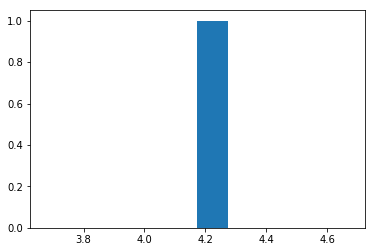

4.174220172128535


In [26]:
listoptions = iters()
plt.hist(listoptions)
plt.show()
print(np.mean(listoptions))

In [ ]:
def analytic_solution(start_price = 100, T = 1, N = 100, r = 0.06, sigma = 0.2):
    mu = (r - 0.5 * sigma**2) * (N + 1) / (2 * N) * T
    sig = sigma**2 * ((N + 1) * (2 * N + 1) / (6 * N**2) * T)
    return  start_price * math.exp(mu + sig**2/2)
    

In [ ]:
plt.hist(option_means)
plt.show()
print(np.mean(option_means))

In [ ]:
np.max(-100, 0)

In [34]:
A = [100.        , 103.42866013, 104.24163974, 102.33814442,  99.82947363,
 101.96695971, 105.56544621, 104.64276439, 105.91023987, 103.05368405,
 101.21435397, 102.84235093, 102.69592301, 101.97060071, 105.6544888,
 105.01445382, 102.88852908, 106.67916672, 106.03968332, 107.03238964,
 107.44324009, 107.07742295, 106.57480482, 101.45037216, 102.38409168,
 101.02825116, 100.73040742, 105.98292982, 107.28073334, 105.44614534,
 104.50759533, 104.91756455, 103.95004954, 102.52979716, 103.4684177,
 100.63269572, 103.64348958, 101.84744884, 100.68455476, 105.44567347,
 108.18161134, 108.3653822 , 108.70198332, 108.15013491, 103.04701187,
 101.84303416, 100.11430493,  97.50135675,  92.57301555,  94.75471219,
  93.6601522 ,  93.47575783,  94.18578158,  93.13617633,  94.22635441,
  96.95786229, 100.14754661,  99.49835395, 104.25697658, 104.50734543,
 105.61269004, 104.02697407, 106.91998583, 109.13863556, 110.79747972,
 114.859821  , 113.80376139, 111.61136972, 107.80185345, 107.13698786,
 104.8614019 , 102.90067114, 101.09805498,  99.22645927,  97.96192662,
  99.15361217, 100.49444095, 100.3471894 , 103.47047139, 103.24023877,
 102.20712872, 105.01515828, 104.9255307 , 108.53429763, 108.81479837,
 105.60741963, 105.44406649, 104.7989703 , 106.93681213, 105.48466356,
 101.79472188, 103.01076912, 102.72631635, 100.6553234 , 102.75604934,
 105.32121029, 105.75515748, 106.58679296, 107.04839374, 104.74151241,
 101.77273689]

prod = 1
for i in range(len(A[1:])):
    prod *= A[i + 1]**(1/len(A[1:]))
print(prod)

103.43233953274516
